# Model-free Reinforcement Learning: Deep Q-Networks


# Contributing group members

    Felipe Casas   
    Huu Duc Nguyen
    Ilyes Toumi
    Kim Huijo

In [1]:
# import all neccessary modules
import numpy as np
import gym
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from copy import copy, deepcopy
import torch.nn.functional as F
import random
%matplotlib inline  
import matplotlib.pyplot as plt

# Create a replay buffer

First, you need to implement a replay buffer to break high correlation between similiar trajectories and neighboring data points. In Task 1.1, you need to initialize the buffer meaning you need to store the maximum memory size, a memory counter and arrays for storing the state, action, reward, next_state, and flags for terminal states. In Task 1.2, you implement to store transitions in the arrrays of the buffer. Last, you need to design a method for sampling randomly from the buffer. 

In [2]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'flag'))

class ReplayBuffer(object):
    # Initialization of the replay buffer:
    # Store the max_size of the buffer and create a counter (int) needed for iterating over the whole buffer when
    # storing transitions
    # Use numpy arrays! Think about the shape of these arrays!
    # The memories should have the following data types:
    # states: float32
    # next_states: float32
    # actions: int64
    # rewards: float32
    # terminal: bool
    def __init__(self, max_size, input_shape):
        ################################################################################

        self.capacity = max_size
        self.input_shape = input_shape
        self.memory = []
        self.position = 0

        ################################################################################

    
    # Store transitions: 
    # Compute the index where you want to store the new transition (Hint: modulo-devision)
    # Store the data of the transition at the appropriate position
    def append(self, state, action, state_, reward, done):
        ################################################################################


        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(state, action, state_, reward, done)
        self.position = (self.position + 1) % self.capacity

        ################################################################################


    # Sample a random batch from the buffer:
    # Return numpy arrays for states, actions, rewards, next_states and terminal flags
    def sample_batch(self, batch_size):
        ################################################################################

        
        return random.sample(self.memory, batch_size)
        
        ################################################################################



Next, instantiate a replay buffer with a maximum size of 10000 and fill the buffer with transitions.

In [3]:
#Initialize replay buffer:
################################################################################


max_size = 10000
input_shape = 4
replay_buffer = ReplayBuffer(max_size, input_shape)

################################################################################


# Fill replay memory:
# Define variables for the number of actions and states
# Generate transitions and fill up the buffer
# First, reset the environment
# Use a loop to generate a trajectory.
# If you encountered a terminal state, leave the loop and start the next trajectory until the buffer is full. 

env = gym.make('CartPole-v0')

################################################################################


memory_filling_steps = 0 #counter for how many transitions have already been stored
while memory_filling_steps < replay_buffer.capacity:
    state, reward, done = env.reset(), 0, False
    while not done:
        action = np.random.choice(2)
        state_, reward, done, _ = env.step(action)
        #if done: reward = np.float32(-1)
        #print(state, action, state_, reward, done)
        replay_buffer.append(state, action, state_, reward, done)
        memory_filling_steps += 1
        state = state_

################################################################################


env.close()

print(len(replay_buffer.memory))
print(memory_filling_steps)
replay_buffer.memory[1]

10000
10024


Transition(state=array([ 0.04117622,  0.34260751,  0.01872239, -0.49394412]), action=0, next_state=array([ 0.04802837,  0.14722659,  0.00884351, -0.19542003]), reward=1.0, flag=False)

# Design the deep Q-network

In the next step, you need to implement a neural net class for the Q-network. The neural net should have the following architecture:

    fully connected: #input_dim -> #hidden_dim
    fully connected: #hidden_dim -> #hidden_dim
    fully connected: #hidden_dim -> #hidden_dim
    fully connected: #hidden_dim -> #n_actions

In [4]:
# Implement the neural network:
class DeepQNetwork(nn.Module):
    def __init__(self,  n_actions, input_dims, hidden_dim, bias):
        super(DeepQNetwork, self).__init__()

        ################################################################################

        
        self.fc1 = nn.Sequential(nn.Linear(input_dims, hidden_dim, bias), nn.BatchNorm1d(hidden_dim), nn.PReLU())
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias), nn.BatchNorm1d(hidden_dim), nn.PReLU())
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias), nn.BatchNorm1d(hidden_dim), nn.PReLU())
        self.fc4 = nn.Linear(hidden_dim, n_actions, bias)
        
        ################################################################################


    def forward(self, state):
        ################################################################################

        
        Q = self.fc1(state)
        Q = self.fc2(Q)
        Q = self.fc3(Q)
        Q = self.fc4(Q)

        ################################################################################

        return Q

In [5]:
# Setting up hyperparameters: 
N_ACTIONS = env.action_space.n
N_STATES = 4
N_HIDDEN_NODES = 256
USE_BIAS = True
EPSILON = 0.05
BATCH_SIZE = 64
WINDOW = 100
REWARD_THRESHOLD = 195
NETWORK_UPDATE_FREQUENCY = 4
NETWORK_SYNC_FREQUENCY = 2000
DEVICE='cpu'
GAMMA = 0.99
MAX_EPISODES = 2000

training_rewards = []
training_loss =[]
update_loss = []
mean_training_rewards = []
sync_eps = []
step_count = 0

Now, initialize a deep Q-network. Additionaly, you need a target Q-network to stabilize learning. Remember the target network is frequently updated with the weights of the Q-net, so copy the weights of the Q-net into the target right at the beginning. Moreover, instantiate an Adam-optimizer for updating the weights of the Q-net. 

In [6]:
#Instantiate the Q-net, the target net, and the Adam optimizer for the Q-net:

################################################################################


#Initialize Deep Q-Net
DQNet = DeepQNetwork(N_ACTIONS, N_STATES, N_HIDDEN_NODES, USE_BIAS).to(DEVICE)

#Initialize Target Deep Q-Net
TargetDQNet = DeepQNetwork(N_ACTIONS, N_STATES, N_HIDDEN_NODES, USE_BIAS).to(DEVICE)

#Save weights in target DQN
TargetDQNet.load_state_dict(DQNet.state_dict())
TargetDQNet.eval()

optimizer = optim.Adam(DQNet.parameters())

################################################################################



# Epsilon-greedy exploration

Next, you need to implement a method for the epsilon-greedy exploration. Epsilon-greedy is a very simple yet effective exploration scheme. If a randomly drawn number between 0 and 1 is less than the epsilon threshold, a random number is chosen, else choose an action according to the greedy policy. 

In [7]:
# Epsilon-greedy:
# First, generate a random number and check if you choose the action randomly or with respect to the greedy policy

def get_action(state, epsilon=0.05):
    ################################################################################

    
    # With a small probability of epsilon, choose a random action
    if np.random.rand()< epsilon:
        return np.random.choice(2)
    # Else, with probability of (1-epsilon), choose the greediest action
    else:
        return greedy_action(state)

    ################################################################################


# Define a method for computing the action according to the greedy policy
# You have to use the Q-net. Therefore, transform the state (numpy state) to a torch tensor and make sure it is 
# available on your computing device (.to())

def greedy_action(state):
    ################################################################################


    # Convert state to tensor
    state = Variable(torch.Tensor(state.reshape(-1, len(state)))).to(DEVICE)
    
    # Get Q Value of all actions
    DQNet.eval()
    scores = DQNet(state)
    
    # Select greediest action
    action = int(torch.argmax(scores))
    
    ################################################################################

    return action

# Computing the loss ...

This is where all magic happens. Compute the mean-squarred error loss of the target Q-values and the Q-values according to the following alogrithm (Hasselt et al. 2015). 

\begin{align}
&for~each~update~step~do\\
&\quad sample ~ e_t=(s_t, a_t, r_t, s_t')\sim D\\
&\quad Compute~target~Q~value:\\
&\quad \quad Q^\star(s_t, a_t) \approx r_t + \gamma Q_\theta(s_{t+1}, argmax_{a'}Q_{\theta'}(s_{t+}, a'))\\
&\quad Perform~gradient~descent~with~MSE~loss~on~(Q^\star(s_t,a_t)-Q_\theta(s_t,a_t))^2\\
\end{align}


In [8]:
# The loss function: 
# First, you need to transform the numpy arrays for the state batch, action batch, reward batch, next state batch
# terminal flag batch into appropriate tensors which are accessable from your computing device.
# Compute the Q-values for the current state and action.
# Compute the the best action under the Q-net for the next state
# Compute the target Q-values for the next state and the best action for the next state
# Zero-out all target Q-values for terminal states
# Compute the expected target Q-values
# Compute the loss for between Q-values and expected target Q-values

def calculate_loss(state_batch, action_batch, reward_batch, new_state_batch, done_batch):
    ################################################################################

    
    # Transform input numpy arrays to tensors
    states = Variable(torch.Tensor(state_batch.reshape(-1, 4)))
    next_states = Variable(torch.Tensor(new_state_batch.reshape(-1, 4)))
    actions = Variable(torch.Tensor(action_batch.reshape(-1))).type(torch.long)
    rewards = Variable(torch.Tensor(reward_batch.reshape(-1)))
    flags = Variable(torch.Tensor(done_batch.reshape(-1))).type(torch.bool)
    
    # Calculate predicted Q value and save it
    DQNet.train(mode=False)
    Q1 = DQNet(states)
    Q_predict = Q1[:,actions].diagonal().clone()
    
    # Get a prime using Double Q-Learning
    a_prime = torch.argmax(DQNet(next_states),axis=1)
    
    # Calculate targeted Q value
    Q_target = rewards + GAMMA * TargetDQNet(next_states)[:,a_prime].diagonal() * ~flags
    
    # Calculate loss value
    DQNet.train(mode=True)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(Q_predict,Q_target)
    
    ################################################################################

    
    return loss

In [9]:
def check_average_reward():
    val_env = gym.make('CartPole-v0')
    policy = deepcopy(q_network)
    policy.eval()
    trajectory_rewards = np.empty((10, 1))
    for i_traj in range(10):
        state, ep_reward = val_env.reset(), 0
        cum_reward = 0
        for t in range(1, 10000):  # Don't infinite loop while learning
            with torch.no_grad():
                state_t = torch.FloatTensor(state).to(device=DEVICE)
                a = policy.forward(state_t)
                argmax_a = torch.max(a, dim=0)[1].item()
            state, reward, done, _ = val_env.step(argmax_a)
            cum_reward += reward
            if done:
                trajectory_rewards[i_traj] = cum_reward
                break
    average_reward = np.mean(trajectory_rewards)
    print(' avg_reward: ', average_reward)

# Putting everything together

Last, you need to put everything together in a training loop. Setup the environment, choose the action according to epsilon-greedy. Take a step and add the transition to the buffer. Every 4 steps, we want to perform an update step on the Q-net and every 2000 steps, we want to synchronize the target Q-net with the Q-net. You have already written all code to train the network, just set it up in an appropriate order.

Visualize your learning performance using a plot. 

In [10]:
minibatch = replay_buffer.sample_batch(BATCH_SIZE)
state_batch = np.array([x.state for x in minibatch])
#print(state_batch)
states = Variable(torch.Tensor(state_batch.reshape(-1, 4)))
#print(states)

In [11]:
# The training loop: 
# choose the action according to epsilon-greedy
# perform the action 
# store the transition in the replay buffer
# Every 4 steps perform an update step on the Q-net. Don't forget to zero the gradients of the optimizer.
#     - Sample a batch from the buffer
#     - compute the loss for the batch
#     - perform the backpropagation through the Q-net
#     - perform an update step on the Q-net using the optimizer
# Every 2000 steps synchronize the target Q-net and the current Q-net

ep = 0
step_count = 0
training = True

while training:
    state = env.reset()
    done = False
    rewards = 0
    while done == False:
        ################################################################################

        
        # Choose Action
        action = get_action(state)
        # Perform Action
        next_state, reward, done, _ = env.step(action)        
        # Count Accumulative rewards
        rewards += reward        
        # Save in Buffer
        replay_buffer.append(state, action, next_state, reward, done)
        # Copy next state
        state = next_state
        
        # Each step:
        step_count += 1        
        
        if step_count % NETWORK_UPDATE_FREQUENCY == 0:            
            # Get batch
            minibatch = replay_buffer.sample_batch(BATCH_SIZE)
            state_batch      = np.array([x.state      for x in minibatch])
            action_batch     = np.array([x.action     for x in minibatch])
            next_state_batch = np.array([x.next_state for x in minibatch])
            reward_batch     = np.array([x.reward     for x in minibatch])
            done_batch       = np.array([x.flag       for x in minibatch])
            # Calculate Loss
            loss = calculate_loss(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
            # Perform a step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            update_loss.append(loss.item())
            
        # Synchronize weights in target DQN every 2000 steps
        #if step_count % NETWORK_SYNC_FREQUENCY == 0:
        if step_count % 100 == 0:            
            TargetDQNet.load_state_dict(DQNet.state_dict())
            TargetDQNet.eval()        

        ################################################################################


        if done:
            ep += 1
            training_rewards.append(rewards)
            training_loss.append(np.mean(update_loss))
            update_loss = []
            mean_rewards = np.mean(training_rewards[-WINDOW:])
            mean_training_rewards.append(mean_rewards)
            print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(ep, mean_rewards), end="")
            if ep >= MAX_EPISODES:
                training = False
                print('\nEpisode limit reached.')
                break                
            if mean_rewards >= REWARD_THRESHOLD:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(ep))
                break

Episode 750 Mean Rewards 195.36		
Environment solved in 750 episodes!


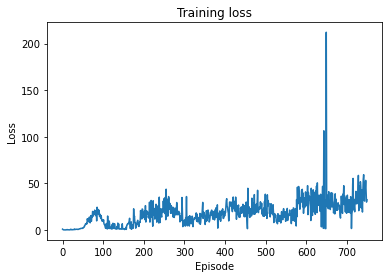

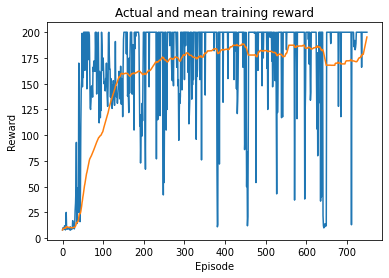

In [12]:
plt.plot(training_loss)
plt.title('Training loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()

plt.plot(training_rewards)
plt.plot(mean_training_rewards)
plt.title('Actual and mean training reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()